### Import the required libraries

In [1]:
import os, sys
import matplotlib.pyplot as plt
import numpy as np 
import PIL 
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from pathlib import Path
import random
import cv2
import warnings
warnings.filterwarnings("ignore")

### Download the dataset

In [2]:
# Classes we have in our data set.
total_classes = os.listdir(r"C:\Users\DELL\Downloads\Dataset")
total_classes

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

In [3]:
# Total number of images per class.
images_path = Path(r"C:\Users\DELL\Downloads\Dataset")

for c in total_classes:
  print(f'* {c}', '=',len(os.listdir(os.path.join(images_path, c))), 'images')

* Mild_Demented = 896 images
* Moderate_Demented = 64 images
* Non_Demented = 3200 images
* Very_Mild_Demented = 2240 images


We can see a class imbalance here !

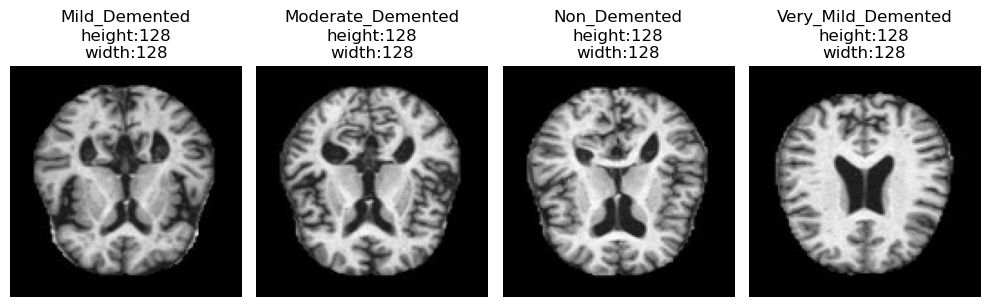

In [4]:
# Let's display 1 image per class.

fig,ax = plt.subplots(1,4,figsize=(10,4))
ax = ax.flat
for i,c in enumerate(total_classes):
  img_total_class = list(Path(os.path.join(images_path, c)).glob("*.jpg"))
  img_selected = random.choice(img_total_class)
  img_BGR = cv2.imread(str(img_selected))
  img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
  height,width,channel = img_RGB.shape
  ax[i].imshow(img_RGB)
  ax[i].set_title(f"{img_selected.parent.stem}\nheight:{height}\nwidth:{width}")
  ax[i].axis("off")

fig.tight_layout()
fig.show()

In [5]:
batch_size = 32
img_height = 180
img_width = 180

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    images_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size = (img_height, img_width),
    batch_size=batch_size)

Found 6400 files belonging to 4 classes.
Using 5120 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    images_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6400 files belonging to 4 classes.
Using 1280 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


### Visualize the data

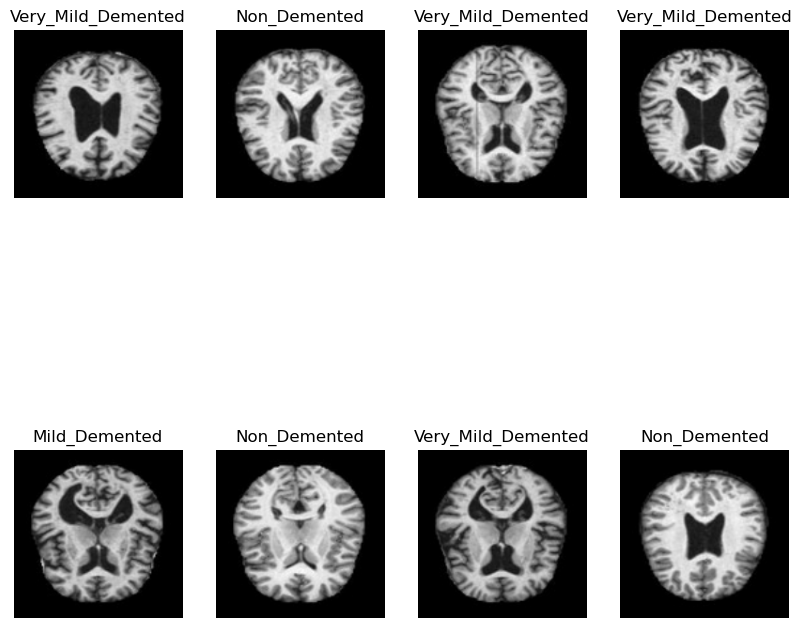

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [10]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


### Configure the data for higher performance

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Standardizing the dataset

In [12]:
normalization_layer = layers.Rescaling(1./255)

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixel values are now in '[0,1]'

print(np.min(first_image), np.max(first_image))

0.0 0.8505326


### Create the Model

In [14]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes)
])

### Compile the Model

In [15]:
model.compile(optimizer="adam",
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=["accuracy"])

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,156 (15.22 MB)

 Trainable params: 3,989,156 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the Model

In [17]:
epochs = 10 

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 51s 278ms/step - accuracy: 0.5001 - loss: 1.0347 - val_accuracy: 0.6703 - val_loss: 0.7579
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 41s 259ms/step - accuracy: 0.6831 - loss: 0.7288 - val_accuracy: 0.7852 - val_loss: 0.4929
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 40s 252ms/step - accuracy: 0.8632 - loss: 0.3634 - val_accuracy: 0.7922 - val_loss: 0.4639
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 37s 230ms/step - accuracy: 0.9481 - loss: 0.1489 - val_accuracy: 0.9062 - val_loss: 0.2315
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 39s 242ms/step - accuracy: 0.9695 - loss: 0.0834 - val_accuracy: 0.9547 - val_loss: 0.1201
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 40s 249ms/step - accuracy: 0.9959 - loss: 0.0201 - val_accuracy: 0.9703 - val_loss: 0.0883
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 39s 247ms/step - accuracy: 0.9988 - loss: 0.0055 - val_accuracy: 0.9883 - val_loss: 0.0415
Epoch 8/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 40s 248ms/step - accuracy: 1.0000 - loss: 7

### Visualizing the results

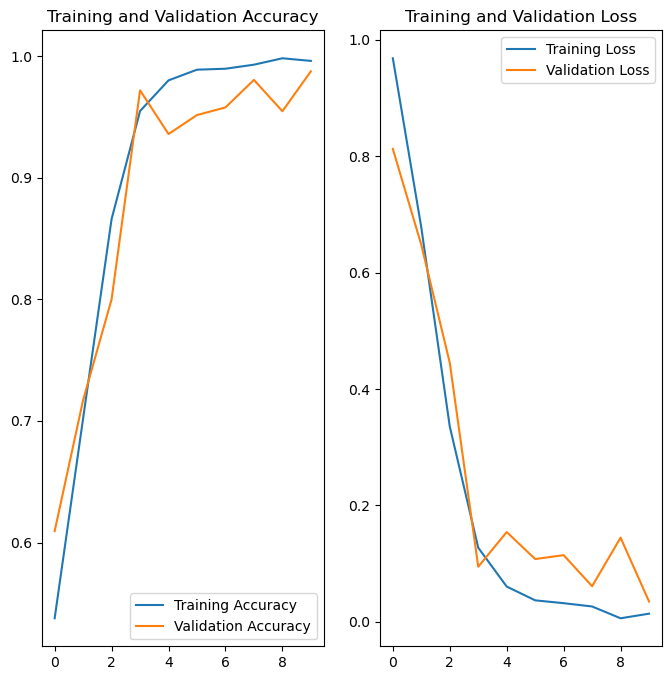

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Data Augmentation

In [19]:
data_augmentation = keras.Sequential(
[
    layers.RandomFlip("horizontal",
                     input_shape=(img_height,
                                 img_width,
                                  3)),
    
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

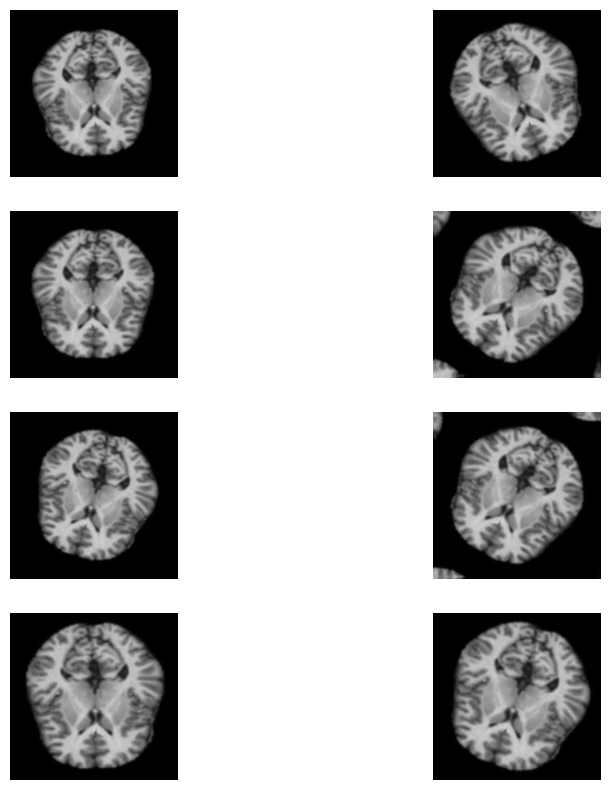

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(8):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(4,2, i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Adding Dropout Layer

In [21]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes)
])

In [22]:
model.compile(optimizer="adam",
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])

In [23]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,156 (15.22 MB)

 Trainable params: 3,989,156 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
epochs = 50

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 31s 191ms/step - accuracy: 1.0000 - loss: 2.2043e-04 - val_accuracy: 0.9883 - val_loss: 0.0365
Epoch 2/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 32s 201ms/step - accuracy: 1.0000 - loss: 1.6369e-04 - val_accuracy: 0.9875 - val_loss: 0.0362
Epoch 3/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 34s 215ms/step - accuracy: 1.0000 - loss: 1.2438e-04 - val_accuracy: 0.9883 - val_loss: 0.0384
Epoch 4/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 31s 196ms/step - accuracy: 1.0000 - loss: 1.2090e-04 - val_accuracy: 0.9875 - val_loss: 0.0363
Epoch 5/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 31s 195ms/step - accuracy: 1.0000 - loss: 1.0327e-04 - val_accuracy: 0.9883 - val_loss: 0.0365
Epoch 6/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 31s 196ms/step - accuracy: 1.0000 - loss: 8.0713e-05 - val_accuracy: 0.9891 - val_loss: 0.0362
Epoch 7/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 34s 211ms/step - accuracy: 1.0000 - loss: 6.9664e-05 - val_accuracy: 0.9883 - val_loss: 0.0366
Epoch 8/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 33s 205ms/step 

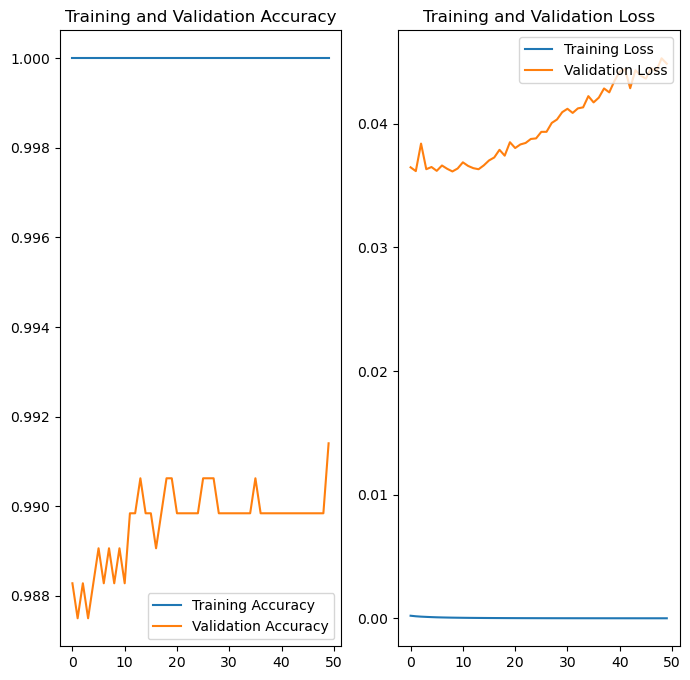

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Save the Model

In [20]:
# Save the Keras model as an HDF5 file
model.save("alzeihmer_model.h5")